# Лабораторная работа № 8.

## Динамические сети

Целью работы является исследование свойств некоторых динамических нейронных сетей, алгоритмов обучения, а также применение сетей в задачах аппроксимации функций и распознавания динамических образов.

In [1]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data.dataloader import default_collate
from tqdm import trange

Проверяю доступность видеокарты

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Всё обучение будет проходить на " + device)

Всё обучение будет проходить на cuda


### NARX

Динаимческая система

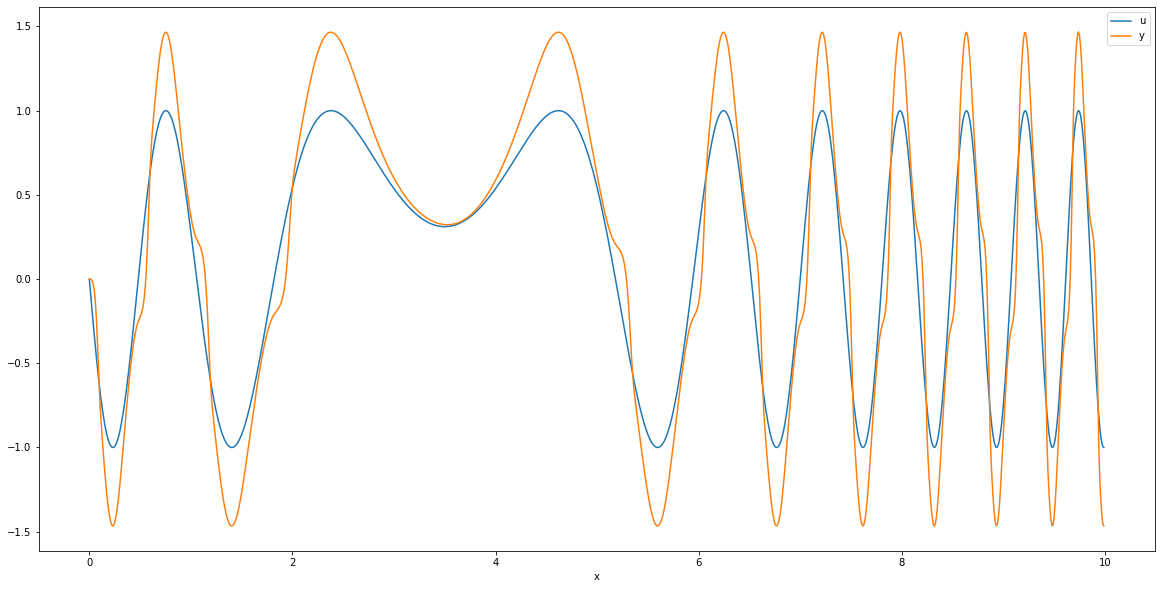

In [3]:
h = 0.01
x = np.arange(0, 10, h)
n = x.shape[0]

u = []
for k in x:
    u.append(np.sin(k**2 - 7 * k))
u = np.array(u)

y = [0]
for i in range(1, n):
    y.append(y[-1] / (1 + y[-1] ** 2) + u[i] ** 3)
y = np.array(y)

figure = plt.figure(figsize=(20, 10))
plt.plot(x, u, label="u")
plt.plot(x, y, label="y")
plt.xlabel("x")
plt.legend()
plt.show()

Подготовка обучающих данных

In [4]:
D = 3

plot_u = u[D:]
train_x, train_y = [], []

for i in range(n - D):
    xx = u[i : i + D]
    yy = y[i : i + D]
    train_x.append(xx)
    train_y.append(yy)

train_x = np.array(train_x)
train_y = np.array(train_y)

train_xy = [(el_x, el_y) for el_x, el_y in zip(train_x, train_y)]

Загрузка данных

In [5]:
def data_to_device(x):
    return tuple(x_.to(device).float() for x_ in default_collate(x))


dl_xy = torch.utils.data.DataLoader(
    train_xy, collate_fn=data_to_device, batch_size=1, shuffle=False
)

Построение модели

In [6]:
class TDL(nn.Module):
    def __init__(self, size_in, delay):
        super().__init__()
        self.size_in = size_in
        self.delay = delay

        self.q = deque()
        self.clear()

    def clear(self):
        self.q.clear()
        for _ in range(self.delay):
            self.q.appendleft(torch.zeros(1, self.size_in).to(device))

    def push(self, x):
        self.q.appendleft(x.clone().detach().requires_grad_(False))

    def get(self):
        return self.q.pop()

In [7]:
class NARX(nn.Module):
    def __init__(self, size_in, size_out, size_hidden, delay):
        super().__init__()
        self.size_in = size_in
        self.size_out = size_out
        self.size_hidden = size_hidden
        self.delay = delay

        self.TDL1 = TDL(size_in, delay)
        self.TDL2 = TDL(size_out, delay)

        self.w1 = nn.Parameter(torch.Tensor(size_in, size_hidden))
        self.w2 = nn.Parameter(torch.Tensor(size_out, size_hidden))
        self.w3 = nn.Parameter(torch.Tensor(size_hidden, size_out))
        self.b1 = nn.Parameter(torch.Tensor(size_hidden))
        self.b3 = nn.Parameter(torch.Tensor(size_out))
        nn.init.uniform_(self.w1)
        nn.init.uniform_(self.w2)
        nn.init.uniform_(self.w3)
        nn.init.zeros_(self.b1)
        nn.init.zeros_(self.b3)

    def clear(self):
        self.TDL1.clear()
        self.TDL2.clear()

    def forward(self, x):
        o1 = self.TDL1.get()
        o2 = self.TDL2.get()
        y = torch.add(torch.matmul(o1, self.w1), torch.matmul(o2, self.w2))
        y = torch.add(y, self.b1)
        y = torch.tanh(y)
        y = torch.add(torch.matmul(y, self.w3), self.b3)

        self.TDL1.push(x)
        self.TDL2.push(y)
        return y

In [8]:
def fit_narx(net, train_xy, epoches=10, lr=1e-3):
    net.train()
    n = len(train_xy)
    optim = torch.optim.Adam(net.parameters(), lr=lr)
    h = {"mse": []}
    for epoch in trange(epoches, desc="Traning NARX", ascii=True):
        net.clear()
        train_loss_ep = 0.0
        for x, y in train_xy:
            z = net(x)
            loss = nn.MSELoss()(z, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            train_loss_ep += loss.detach().cpu().item() / n
        h["mse"].append(train_loss_ep)

    net.eval()
    net.clear()
    p = []
    plot_y = []
    for x, y in train_xy:
        z = net(x)
        p.append(z.cpu().detach().numpy()[0][-1])
        plot_y.append(y.cpu().detach().numpy()[0][-1])
    p = np.array(p)
    plot_y = np.array(plot_y)

    figure = plt.figure(figsize=(20, 20))
    axes = figure.add_subplot(211)
    plt.plot(h["mse"])
    plt.ylabel("MSE")
    plt.xlabel("Эпохи")

    axes = figure.add_subplot(212)
    plt.plot(plot_u, label="u")
    plt.plot(plot_y, label="y")
    plt.plot(p, label="p")
    plt.xlabel("x")
    plt.legend()

    plt.show()

    del optim

    if device == "cuda":
        torch.cuda.empty_cache()

In [9]:
model = NARX(D, D, 10, 3).to(device)

Обучение и визуализация результатов

Traning NARX: 100%|#########################################################################################################################################| 200/200 [03:49<00:00,  1.15s/it]


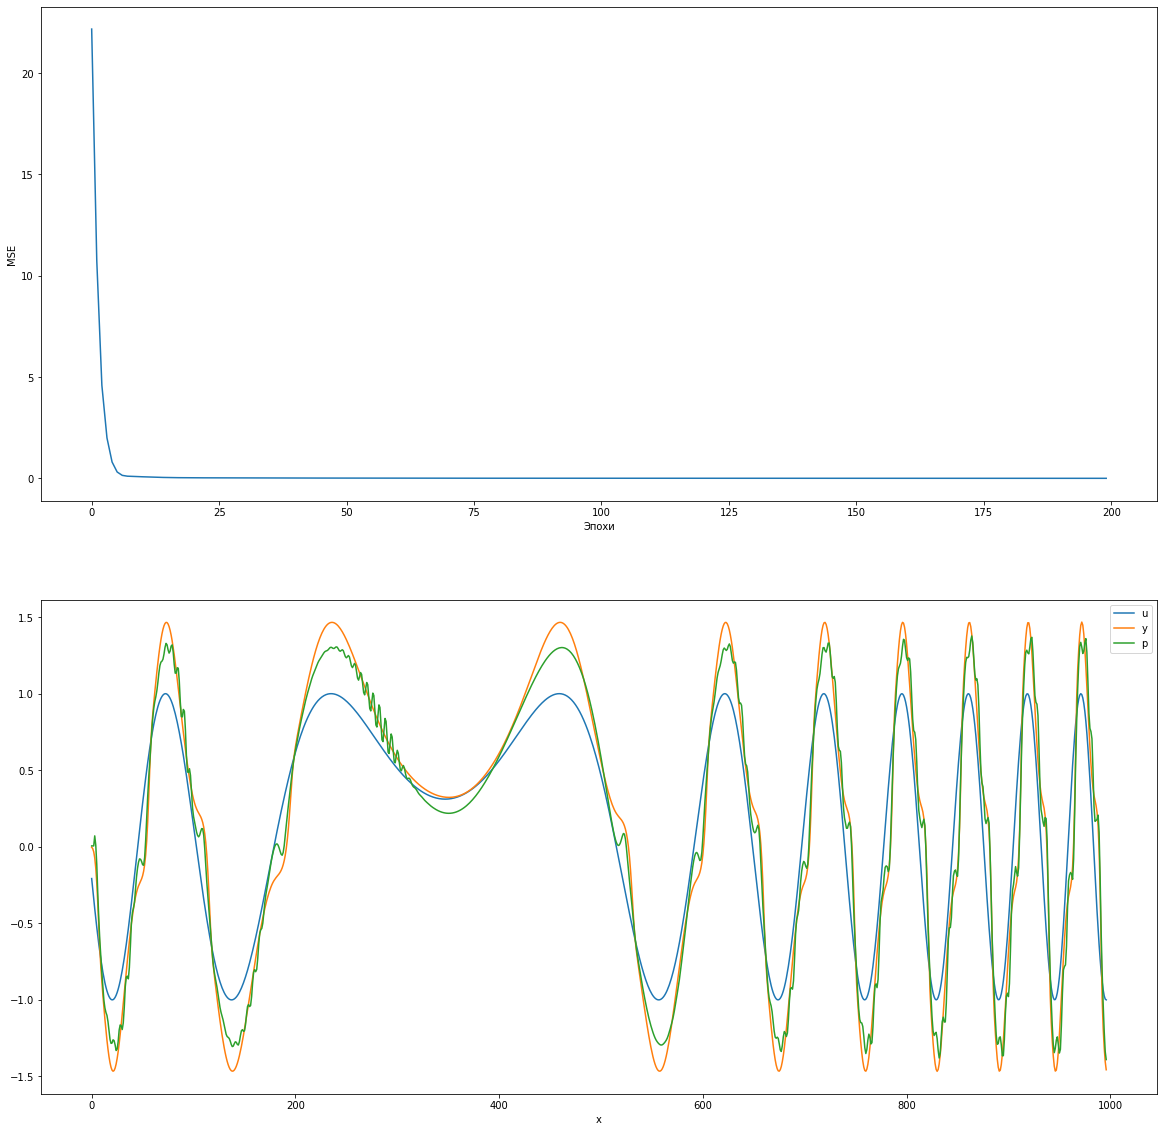

In [10]:
fit_narx(model, dl_xy, 200, 1e-4)

### Вывод

В ходе выполнения лабораторной работы я ознакомился с нелинейной авторегрессионой экзогенной моделью (NARX), реализовал с её помощью распознавание динамического образа.